In [1]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
from scipy.interpolate import interp1d
import scipy.stats as si  #for gaussian cdf
from scipy import optimize
import time, sys
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def error(AV,AV2,n,l):  # Function for statistical uncertainty estimation
    """Error Function"""
    if n==0:
        return 0
    else:
        return np.sqrt((AV2[n][l] - AV[n][l]**2)/n)


def Monte_Carlo_Analisys(data,N_block): #method to check convergence of the MC result
    """Data blocking method"""
    N = N_block
    M= int(len(data))              # Total number of throws
    L=int(M/N)           # Number of throws in each block, please use for M a multiple of N
    K = int(len(data.T))
    ave = np.zeros((N,K))
    av2 = np.zeros((N,K))
    sum_prog = np.zeros((N,K))
    su2_prog = np.zeros((N,K))
    err_prog = np.zeros((N,K))
    x = np.arange(N)
    x*=L
    for l in range(K):
        for i in range(N):
            sum = 0
            for j in range(L):
                k = j+i*L
                sum += data[k][l]
            ave[i][l] = sum/L   
            av2[i][l] = (ave[i][l])**2  
    for l in range (K):
        for i in range(N):
            for j in range(i+1):
                sum_prog[i][l] += ave[j][l] # SUM_{j=0,i} r_j
                su2_prog[i][l] += av2[j][l] # SUM_{j=0,i} (r_j)^2
            sum_prog[i][l]/=(i+1) # Cumulative average
            su2_prog[i][l]/=(i+1) # Cumulative square average
            err_prog[i][l] = error(sum_prog,su2_prog,i,l) # Statistical uncertainty
        
    
    return x,sum_prog,err_prog
    

In [3]:
def MC(data):
    """mean and error of MC simulation"""
    mean = np.mean(data,axis=0)
    std = np.std(data,axis=0)/np.sqrt(len(data))
    return mean, std

In [4]:
def d1(S, K, T, r, q, sigma):
    """d_1 function for BS model"""
    return (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

def d2(S, K, T, r, q, sigma):
    """d_2 function for BS model"""
    return  (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

def Call_Closed(S, K, T, r, q, sigma):
    """Closed form of Call Option for BS model"""
    d_1 = d1(S, K, T, r, q, sigma)
    d_2 = d2(S, K, T, r, q, sigma)
    return S * np.exp(-q * T) * si.norm.cdf(d_1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d_2, 0.0, 1.0) 

def vega(S, K, T, r, q, sigma):
    """Vega"""
    d_1 = d1(S, K, T, r, q, sigma)
    return (1 / np.sqrt(2 * np.pi)) * S * np.exp(-q * T) * np.sqrt(T) * np.exp((-d_1 ** 2) * 0.5)

In [5]:
class Curve:
  
    def __init__(self, **kwargs):
      
        raise Exception('do not instantiate this class.')

    def __call__(self, date): #return the value of the curve at a defined time 
      
        return self.curve(date)


class EquityForwardCurve(Curve):
   
    def __init__(self, spot=None, reference=None, discounting_curve=None,
                repo_rates=None, repo_dates=None, dividend_rates=None, dividend_dates=None): #discounting_curve is a a DiscountingCurve type object
        self.spot = spot
        self.reference = reference  #pricing date (t_0)
        self.discounting_curve = discounting_curve
        #self.repo_rates = interp1d(repo_dates, repo_rates)  #Linear interpolation inside the constructor since it is done only once
        #self.dividend_rates = interp1d(dividend_dates, dividend_rates)
        
    def curve(self, date):
        return (self.spot/self.discounting_curve(date))#*np.exp(-(self.dividend_rates(date)+self.repo_rates(date))*date)
        
    


class DiscountingCurve(Curve):

    def __init__(self, reference=None, discounts=None, dates=None):
       
        self.reference = reference
        self.discounts = interp1d(dates, discounts)
        
    def curve(self, date):  
        return np.exp(-self.discounts(date-self.reference)*(date-self.reference))


class PricingModel:
   
    def __init__(self, **kwargs):
      
      raise Exception('model not implemented.')

    def simulate(self, fixings=None, Nsim=1, seed=14, **kwargs):
     
      raise Exception('simulate not implemented.')


class Black(PricingModel):
    """Black model"""
    
    def __init__(self, volatility=None, forward_curve=None, fixings=None, **kwargs):
        self.volatility = volatility
        self.forward_curve = forward_curve(fixings)  #K/F_0(T)
        self.fixings = fixings# - forward_curve.reference  #self.fixings = t_i - t_0
       
    def setSeed(self, seed):
        rnd.seed(seed)
        
    def simulate(self, Nsim,**kwargs): #simulation of Martingale
        self.martingale = np.zeros((Nsim,len(self.fixings)))
        for i in range (Nsim):
            for j in range (len(self.fixings)):
                Z = rnd.gauss(0,1)
                self.martingale[i][j] = np.exp(-0.5*(self.volatility**2)*self.fixings[j]+self.volatility*np.sqrt(self.fixings[j])*Z)
    
    def Call_PayOff(self,strike): #Monte Carlo call payoff
        self.h = strike/self.forward_curve
        self.pay = self.martingale- self.h  
        for i in range (len(self.martingale)):
            for j in range (len(self.fixings)):
                self.pay[i][j] = max(self.pay[i][j],0)
        
    def newton_vol_call_div(self, S, C, i, r=0, q=0):  
        """Implied volatility"""
        xold = 0 
        xnew = np.sqrt((2*np.pi)/self.fixings[i])*(C[i]/S[i]) 
        tolerance = 0.0001
        counter = 0
        while abs(xnew - xold) > tolerance:
            xold = xnew
            f = Call_Closed(S[i], self.h[i], self.fixings[i], r, q, xold)
            v = vega(S[i], self.h[i], self.fixings[i], r, q, xold)
            xnew = xold - (f-C[i])/ v
            counter= counter +1
            if(counter>=1000):
                return None
        return abs(xnew)

In [6]:
Nsim = int(1e6)
volatility = 20/100
reference = 0
spot = 150
npoints = 100  #number of maturities and strikes
discount = 1/100
strike = np.linspace(0,300,npoints)
maturities = np.linspace(0.0001,3.,npoints)
print("Black & Scholes model \n\n")
print("N simulation: ",Nsim,"\n")
print("Volatility: ",volatility,"\n")
print("Costant discount factor: ",discount,"\n")
print("Spot price: ",spot,"\n")
print("Reference: ",reference,"\n")
print("Number of maturities and strikes: ",npoints,"\n")

Black & Scholes model 


N simulation:  1000000 

Volatility:  0.2 

Costant discount factor:  0.01 

Spot price:  150 

Reference:  0 

Number of maturities and strikes:  100 



In [7]:
r_dates = np.linspace(0,7,10)
r = np.ones(10)*discount
discounting_curve = DiscountingCurve(reference,r,r_dates)
forward = EquityForwardCurve(spot,reference,discounting_curve)

In [8]:
bs = Black(volatility,forward,maturities)
bs.setSeed(10)

In [9]:
start_time = time.time()
print("Martingale: Start \n")
bs.simulate(Nsim)
print("Martingale: Done \n")
print("Execution time: ---%s min ---" %((time.time()-start_time)/60))

Martingale: Start 

Martingale: Done 



### Analisys of the convergence of MC results for a fixed strike using data blocking method

In [10]:
strike_price = 150
bs.Call_PayOff(strike_price)
x, mean, err = Monte_Carlo_Analisys(bs.pay,100)

In [11]:
#calculating closed of call option
call_black = Call_Closed(spot,strike_price,maturities,discount,0,volatility)

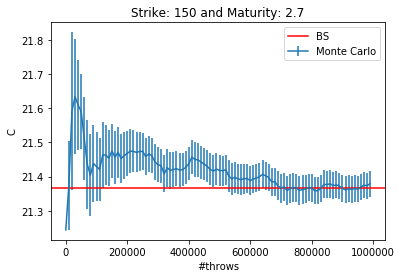

In [75]:
n = 89

mean_price = mean.T[n]*forward(maturities[n])*discounting_curve(maturities[n])
err_price = err.T[n]*forward(maturities[n])*discounting_curve(maturities[n])


plt.errorbar(x,mean_price,yerr=err_price,label = 'Monte Carlo')
plt.axhline(y=call_black[n], color = 'red',linestyle='-',label = 'BS')
plt.xlabel("#throws")
plt.ylabel('C')
plt.title("Strike: "+str(strike_price)+" and Maturity: "+str(round(maturities[n],2)))
plt.legend()
#plt.savefig('Results/Data Blocking_correct.pdf')
plt.show()

/home/ste/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


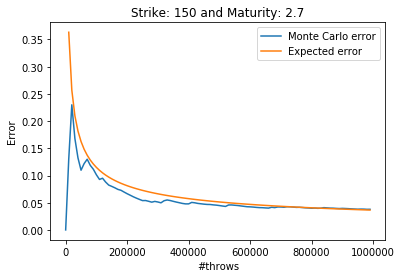

In [74]:
z = np.std(bs.pay.T[n])*forward(maturities[n])*discounting_curve(maturities[n])
y = np.sqrt(x)
plt.plot(x,err_price, label = 'Monte Carlo error')
plt.plot(x,z/y, label = 'Expected error')
plt.xlabel("#throws")
plt.ylabel('Error')
plt.title("Strike: "+str(strike_price)+" and Maturity: "+str(round(maturities[n],2)))
plt.legend()
#plt.savefig('Results/Error_correct.pdf')
plt.show()

### Result for a fixed strike K = 150 in pricing therms

In [14]:
result, result_err = MC(bs.pay)*discounting_curve(maturities)*forward(maturities)

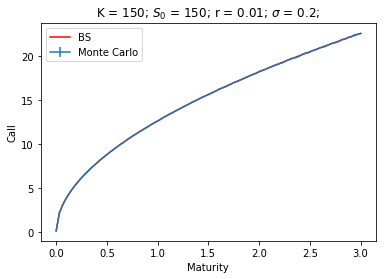

In [73]:
plt.errorbar(maturities,result,yerr=result_err,label = 'Monte Carlo')
plt.plot(maturities,call_black, color = 'red',label = 'BS')
plt.xlabel("Maturity")
plt.title("K = "+str(strike_price)+"; $S_0$ = "+str(spot)+"; r = "+str(discount)+"; $\sigma$ = "+str(volatility)+";")
plt.ylabel('Call')
plt.legend()

#plt.xlim(2.1,2.2)
#plt.ylim(18.6,19)
#plt.savefig('Results/Zoom_2_Pricing_Calls_strike'+str(strike_price)+'.pdf')
plt.show()

### Implied volatility simulation

In [67]:
string = "Data5"
K = np.loadtxt("/home/ste/Desktop/OTV/Results/"+string+"/K_matrix_for_nKT100_nMC1000000.txt")
T = np.loadtxt("/home/ste/Desktop/OTV/Results/"+string+"/T_matrix_for_nKT100_nMC1000000.txt")
implied_volatility = np.loadtxt("//home/ste/Desktop/OTV/Results/"+string+"/implied_volatility_for_nKT100_nMC1000000.txt")
err_implied_volatility = np.loadtxt("/home/ste/Desktop/OTV/Results/"+string+"/err_implied_volatility_for_nKT100_nMC1000000.txt")

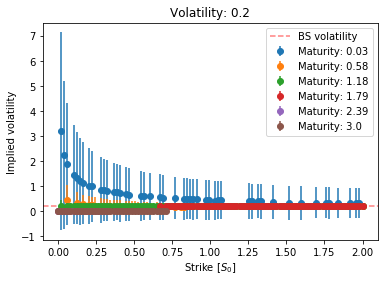

In [72]:
c = 2
num = [1,19,39,59,79,99]
for i in range (len(num)):
    plt.errorbar(K[:][0]/spot,implied_volatility[:][num[i]],yerr=err_implied_volatility[:][num[i]],fmt='o',label="Maturity: "+str(round(T[num[i]][num[i]],c)))
    
plt.xlabel("Strike [$S_0$]")
plt.axhline(y=volatility, color = 'red',alpha = 0.5,linestyle='--',label = 'BS volatility')
plt.title('Volatility: '+str(volatility))
plt.ylabel("Implied volatility")
plt.legend()
#plt.savefig("Implied_volatility_T_fixed.pdf")
plt.show()

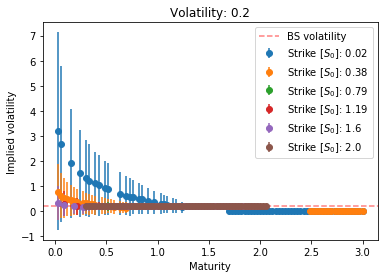

In [71]:
num = [1,19,39,59,79,99]
for i in range (len(num)):
    plt.errorbar(T.T[:][0],implied_volatility.T[num[i]][:],yerr=err_implied_volatility.T[num[i]][:],fmt='o',label="Strike [$S_0$]: "+str(round(K[num[i]][num[i]]/spot,c)))
    
    
plt.axhline(y=volatility, color = 'red',alpha = 0.5,linestyle='--',label = 'BS volatility')
plt.xlabel("Maturity")
plt.ylabel("Implied volatility")
plt.title('Volatility: '+str(volatility))
plt.legend()
#plt.savefig("Implied_volatility_K_fixed.pdf")
plt.show()

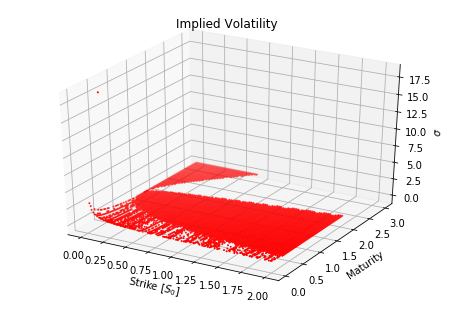

In [70]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(K/spot,T, implied_volatility, c="red",marker='.',s=4)
ax.set_xlabel('Strike $[S_0]$')
ax.set_ylabel('Maturity')
ax.set_zlabel('$\sigma$')
plt.title('Implied Volatility')
#plt.savefig('Implied_vol_2d.pdf')
plt.show()

In [32]:
def newton_vol_call_div(S,C,h,fixings, r, q):
        """Implied volatility"""
        xold = 0 
        xnew = np.sqrt((2*np.pi)/fixings)*(C/S) 
        tolerance = 0.0001
        counter = 0
        
        while abs(xnew - xold) > tolerance:
            xold = xnew
            d_1 = d1(S, h, fixings, r, q, xold)
            d_2 = d_1 - xold*np.sqrt(fixings)
            f = Call_Closed(S, h,fixings, r, q, d_1, d_2)
            v = vega(S, fixings, q, d_1)
            xnew = xold - (f-C)/ v
            counter= counter +1
            if(counter>=1000):
                return None
        return abs(xnew)

In [37]:
S_0 = 100
K = 150
r = 1./100
C = 89.90
T = 365/365
espo = S_0*np.exp(r*T)

In [38]:
newton_vol_call_div(1,C/S_0,K/espo,T,0,0)

3.4641501417742466